In [16]:
# IMPORTS

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import ast

In [17]:
# IMPORT DATA

directory = ".\Data"
all_files = os.listdir(directory)
csv_files = [f for f in all_files if f.endswith(".csv")]

data_list = []

for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path, encoding="latin-1")
    data_list.append(df)

data_concat = pd.concat(data_list, ignore_index=True)

In [18]:
# CLEAN DATAFRAME

data_concat = data_concat.drop(columns=["OBJECTID", "NUMERO_ORDINE", "TECNICO", "ID", "TIPOLOGIA"])

In [19]:
# ADJUST DATE FORMAT
data_concat["DATA_RILEVAMENTO"] = pd.to_datetime(data_concat.DATA_RILEVAMENTO, format="mixed")

In [20]:
# ADJUST SPECIES NAMES

# Remove non-species
data_concat = data_concat[~data_concat["SPECIE"].isin(["06", "****", "nan"]) & ~data_concat["SPECIE"].isna()]

# Group same species under same name (replacement dictionaries are in "Species.txt")
with open("Species.txt", "r") as file:
    file_content = file.read()

replacement_dict_list = ast.literal_eval(file_content)
for replacement_dict in replacement_dict_list:
    data_concat["SPECIE"] = data_concat["SPECIE"].replace(replacement_dict)

display(data_concat)

,DATA_RILEVAMENTO,SPECIE,LATITUDINE,LONGITUDINE,CULTIVAR,RISULTATO,COMUNE,SINTOMO
0,2013-11-25,Oleandro (Nerium oleander),40.503611,16.970000,****,NEGATIVO,PALAGIANO,NaN
1,2013-11-25,Malva (Malva sylvestris L.),40.503611,16.970000,****,NEGATIVO,PALAGIANO,NaN
2,2013-11-25,Olivo (Olea europaea),40.498611,16.946389,****,NEGATIVO,CASTELLANETA,NaN
3,2013-11-25,Malva (Malva sylvestris L.),40.498611,16.946389,****,NEGATIVO,CASTELLANETA,NaN
4,2013-11-25,Olivo (Olea europaea),40.490556,16.923056,****,NEGATIVO,CASTELLANETA,NaN
...,...,...,...,...,...,...,...,...
1197324,2023-06-30,Agrume (di ogni specie),40.544074,17.142576,NaN,Negativo,Taranto,Assente
1197325,2023-06-30,Olivo (Olea europaea),40.535728,17.144692,Leccino,Negativo,Taranto,Assente
1197326,2023-06-13,Olivo (Olea europaea),41.068225,16.950864,ogliarola,Negativo,Triggiano,Presente
1197327,2023-06-14,Olivo (Olea europaea),40.826407,17.385544,ogliarola,Positivo,Fasano,Presente


In [21]:
# ADJUST CASE IN OTHER COLUMNS
column_list = ["CULTIVAR", "RISULTATO", "COMUNE", "SINTOMO"]

for column in column_list:
    data_concat[column] = data_concat[column].str.capitalize()
display(data_concat)

,DATA_RILEVAMENTO,SPECIE,LATITUDINE,LONGITUDINE,CULTIVAR,RISULTATO,COMUNE,SINTOMO
0,2013-11-25,Oleandro (Nerium oleander),40.503611,16.970000,****,Negativo,Palagiano,NaN
1,2013-11-25,Malva (Malva sylvestris L.),40.503611,16.970000,****,Negativo,Palagiano,NaN
2,2013-11-25,Olivo (Olea europaea),40.498611,16.946389,****,Negativo,Castellaneta,NaN
3,2013-11-25,Malva (Malva sylvestris L.),40.498611,16.946389,****,Negativo,Castellaneta,NaN
4,2013-11-25,Olivo (Olea europaea),40.490556,16.923056,****,Negativo,Castellaneta,NaN
...,...,...,...,...,...,...,...,...
1197324,2023-06-30,Agrume (di ogni specie),40.544074,17.142576,NaN,Negativo,Taranto,Assente
1197325,2023-06-30,Olivo (Olea europaea),40.535728,17.144692,Leccino,Negativo,Taranto,Assente
1197326,2023-06-13,Olivo (Olea europaea),41.068225,16.950864,Ogliarola,Negativo,Triggiano,Presente
1197327,2023-06-14,Olivo (Olea europaea),40.826407,17.385544,Ogliarola,Positivo,Fasano,Presente


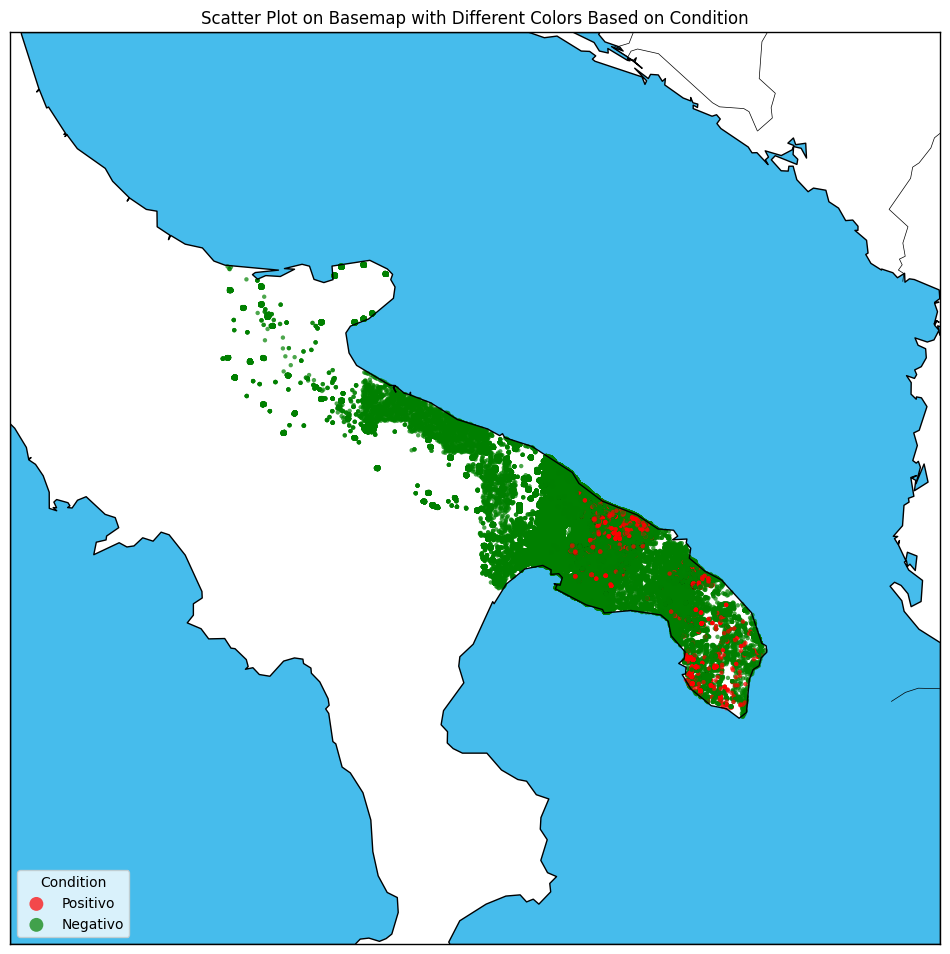

In [22]:
# read in data to use for plotted points
size = 50000
lat = data_concat["LATITUDINE"].values
lon = data_concat["LONGITUDINE"].values

# determine range to print based on min, max lat and lon of the data
margin = 1 # buffer to add to the range
# lat_min = min(lat) - margin
# lat_max = max(lat) + margin
# lon_min = min(lon) - margin
# lon_max = max(lon) + margin

lat_min = 39.7 - margin
lat_max = 42.0 + margin
lon_min = 14.8 - margin
lon_max = 18.6 + margin

color_map = {'Positivo': 'red', 'Negativo': 'green'}
data_concat['color'] = data_concat['RISULTATO'].map(color_map)


fig, ax = plt.subplots(figsize=(12, 12))
# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'i',
            area_thresh=10000.,
            ax = ax
            )

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='white',lake_color='#46bcec')

# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
sc = m.scatter(lons, lats, c=data_concat['color'].values, marker='o', s=10, edgecolor='none', alpha=0.7)

# Create a custom legend
for condition in color_map:
    ax.scatter([], [], c=color_map[condition], edgecolor='none', alpha=0.7, s=100, label=condition)
ax.legend(title='Condition', loc='lower left')

# # plot points as red dots
# m.scatter(lons, lats, marker = 'o', color='r', s=0.1)# zorder=5)

# Show the plot
plt.title('Scatter Plot on Basemap with Different Colors Based on Condition')
plt.show()


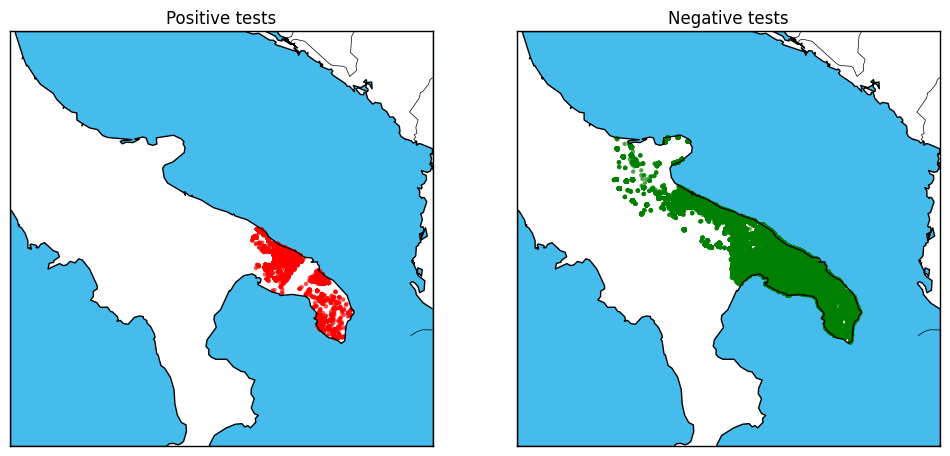

In [23]:
# Plot only positive or negatives
positives = data_concat[data_concat["RISULTATO"] == "Positivo"]
negatives = data_concat[data_concat["RISULTATO"] == "Negativo"]

lat_pos = positives["LATITUDINE"].values
lon_pos = positives["LONGITUDINE"].values
lat_neg = negatives["LATITUDINE"].values
lon_neg = negatives["LONGITUDINE"].values

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# create map using BASEMAP
m1 = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'i',
            area_thresh=10000.,
            ax = ax[0]
            )

m1.drawcoastlines()
m1.drawcountries()
m1.drawstates()
m1.drawmapboundary(fill_color='#46bcec')
m1.fillcontinents(color='white',lake_color='#46bcec')

lons_pos, lats_pos = m1(lon_pos, lat_pos)
m1.scatter(lons_pos, lats_pos, c="red", marker='o', s=10, edgecolor='none', alpha=0.7)

m2 = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'i',
            area_thresh=10000.,
            ax = ax[1]
            )

m2.drawcoastlines()
m2.drawcountries()
m2.drawstates()
m2.drawmapboundary(fill_color='#46bcec')
m2.fillcontinents(color='white',lake_color='#46bcec')

lons_neg, lats_neg = m2(lon_neg, lat_neg)
m2.scatter(lons_neg, lats_neg, c="green", marker='o', s=10, edgecolor='none', alpha=0.7)

# Show the plot
ax[0].set_title('Positive tests')
ax[1].set_title('Negative tests')
plt.show()


In [24]:
n_positives = len(positives)
n_negatives = len(negatives)
print(f"Percentage of positive tests: {np.round(n_positives / (n_positives + n_negatives) * 100, decimals=2)}%")

Percentage of positive tests: 1.4%


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

data_new = data_concat.sort_values(by='DATA_RILEVAMENTO')
# size = 10000
# data_new = data_new[:size]
# print(len(data_new))
# display(data_new)

# Define colors based on the test result
color_map = {'Positivo': 'red', 'Negativo': 'green'}
data_new['color'] = data_new['RISULTATO'].map(color_map)

# Create figure and Basemap
fig, ax = plt.subplots(figsize=(10, 8))
m = Basemap(projection='merc', 
            llcrnrlat=lat_min, 
            urcrnrlat=lat_max, 
            llcrnrlon=lon_min, 
            urcrnrlon=lon_max, 
            resolution='i', 
            ax=ax)

# Draw map details
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgreen', lake_color='aqua')

# Function to update scatter plot for each frame
def update(frame):
    ax.clear()
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgreen', lake_color='aqua')
    
    # Get data up to the current frame
    current_date = unique_dates[frame]
    current_data = data_new[data_new['DATA_RILEVAMENTO'] <= current_date]
    
    # Plot scatter points
    x, y = m(current_data['LONGITUDINE'].values, current_data['LATITUDINE'].values)
    sc = m.scatter(x, y, c=current_data['color'].values, marker='o', s=10, edgecolor='none', alpha=0.7)
    
    # Set the title
    ax.set_title(f'Test Results as of {current_date.date()}')

# Extract unique dates for frames
unique_dates = data_new['DATA_RILEVAMENTO'].unique()

# Create animation
ani = FuncAnimation(fig, update, frames=len(unique_dates), repeat=False)

# Save animation as a video file (optional)
ani.save('epidemic_evolution.gif',
          writer=PillowWriter(fps=10))

# Display animation
plt.show()


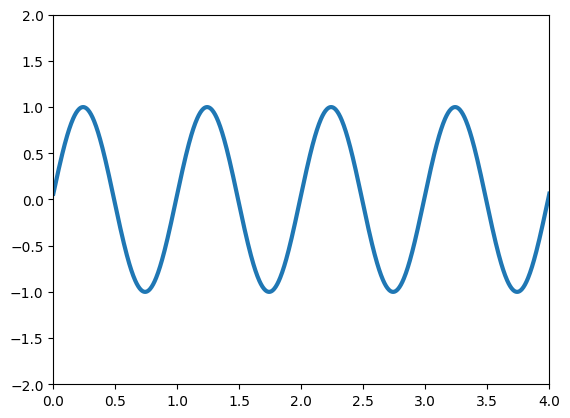

In [41]:
# from matplotlib import pyplot as plt 
# import numpy as np 
# from matplotlib.animation import FuncAnimation, PillowWriter
   
# # initializing a figure in  
# # which the graph will be plotted 
# fig = plt.figure()  
   
# # marking the x-axis and y-axis 
# axis = plt.axes(xlim =(0, 4),  
#                 ylim =(-2, 2))  
  
# # initializing a line variable 
# line, = axis.plot([], [], lw = 3)  
   
# # data which the line will  
# # contain (x, y) 
# def init():  
#     line.set_data([], []) 
#     return line, 
   
# def animate(i): 
#     x = np.linspace(0, 4, 1000) 
   
#     # plots a sine graph 
#     y = np.sin(2 * np.pi * (x - 0.01 * i)) 
#     line.set_data(x, y) 
      
#     return line, 
   
# anim = FuncAnimation(fig, animate, init_func = init, 
#                      frames = 200, interval = 20, blit = True) 
  
   
# anim.save('continuousSineWave.gif',
#           writer=PillowWriter(fps=10))
